In [1]:
#Zfit is a convenient interface for fitting and various minimisation algorithms,
#it might be over kill for our purposes. You may prefer scipy optimise, or other
#algorithms.

import zfit

/home/mmccann/work/teaching/labs/trial/labs/lib/python3.10/site-packages/zfit/__init__.py:63: UserWarning: TensorFlow warnings are by default suppressed by zfit. In order to show them, set the environment variable ZFIT_DISABLE_TF_WARNINGS=0. In order to suppress the TensorFlow warnings AND this warning, set ZFIT_DISABLE_TF_WARNINGS=1.
  warnings.warn(


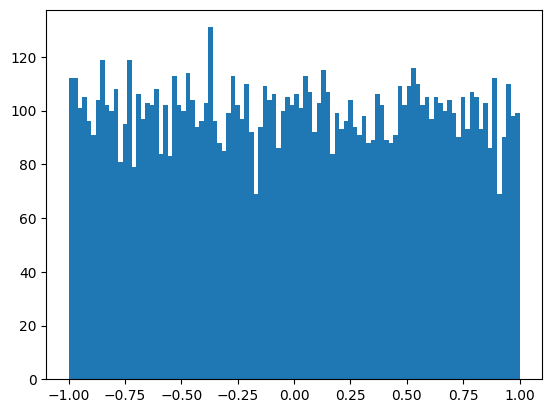

In [2]:
#Neutrino analyses typically use templates that are produced through a
#simulation, and comparing that template generated with different parameters
#to the measured data to find the best matched parameters.

#Typically, generating a full simulation is quite computationally intensive
#So it is generally not possible to have it generated with many different
#value of parameters, especially when there are multiple parameters.

#Instead one can generate a simulation to model the complicated interactions
#with the detector once, and adjust the relative populations of each interaction
#in the useful physics parameters. This has pros and cons, it's worth discussing
#both with a demonstrator.

#Here we will provide an example of extracting the mean and width of a
#Guassian in data, from a template that really doesn't look like that
#initially. A somewhat extreme case.

#Lets make some dataset that will be the template for the shape we want to fit.
#This will substitute for our "fully simulated distribution". For simplicity
#we're going to make it uniform in [-1,1], it won't be in your case

import numpy

template = numpy.array([numpy.random.uniform(-1, 1) for i in range(10000)])

from matplotlib import pyplot as plt 
plt.hist(template, bins=100)
plt.show()

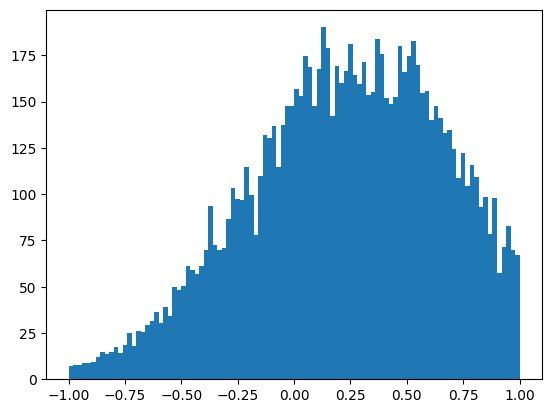

In [3]:
#Let's make a function that will produce weights to make the template look like
#a gaussian with some mean and width, and normalise so the sum of weights is
#always constant (we're assuming the number of events isn't dependent on the parameters)

def makeGaussianWeights(data, mean, width):
    weights = numpy.exp(-0.5*( (data - mean)/width )**2)
    return weights/sum(weights)*len(data)

plt.hist(template, bins=100, weights = makeGaussianWeights(template, 0.3, 0.5))
plt.show()

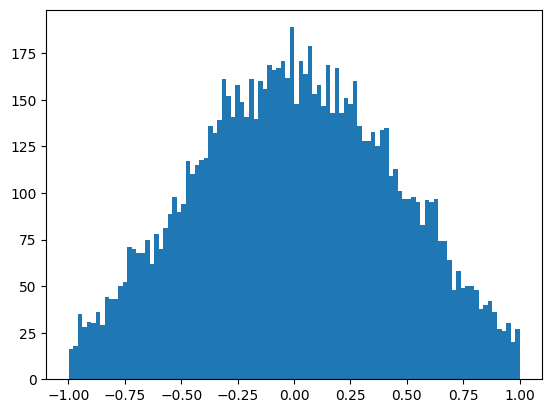

In [4]:
#Let's make a trial data set to extract the parameters from, for which we
#already know the parameters. e.g. mean = 0 and width = 0.5. To be consistent
#We'll restrict the range of our dataset to be [-1,1]

d = []
for i in range(10000):
  x = -2
  while not -1 <= x < 1:
    x = numpy.random.normal(0, 0.5)
  d.append(x)

data = numpy.array(d)

plt.hist(data, bins=100)
plt.show()

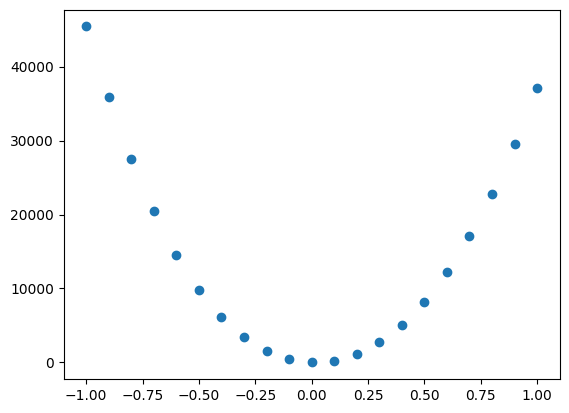

In [5]:
#we can compute a binned chi2 to compare the data to the weighted model.
#Note that we're not being careful with uncertainties
def chi2(data, model, weights):
    dh = numpy.histogram(data, bins=100, range=(-1,1))
    mh = numpy.histogram(model, bins=100, range=(-1,1), weights = weights)
    chi2 = sum((dh[0] - mh[0])**2/dh[0])
    return chi2

#We can do a quick scan across some of the parameter space
x = []
y = []
for mean in [-1 + i/10 for i in range(21)]:
  x.append(mean)
  y.append(chi2(data, template, makeGaussianWeights(template, mean, 0.5)))

plt.scatter(x,y-min(y))
plt.show()

In [6]:
#We could also use a minimiser to find the best parameter set

#The zfit minimisers want a function that takes a vector of the parameters
#We'll make one where the mean is the zeroth element and the width is the first
def wrappedChi2(x):
  return chi2(data, template, makeGaussianWeights(template, x[0], x[1]))

#We'll tell zfit what our parameters are
mean = zfit.param.Parameter('mean', 0)
width = zfit.param.Parameter('width', 1)

#We'll tell it the function to minimise is the one above, wrt our parameters
loss = zfit.loss.SimpleLoss(wrappedChi2, [mean, width], errordef=1)

#We'll use the Minuit algorithm, this is a robust gradient decent minimiser
#The algorithm was developed over many years and is ubiquitous in particle
#physics. There are other algorithms, and you may wish to explore them.
minimiser = zfit.minimize.Minuit()
minimiser.minimize(loss)

FitResult of
<SimpleLoss model=[] data=[] constraints=[]> 
with
<Minuit Minuit tol=0.001>

╒═════════╤═════════════╤══════════════════╤═════════╤══════════════════════════════╕
│  valid  │  converged  │  param at limit  │   edm   │   approx. fmin (full | opt.) │
╞═════════╪═════════════╪══════════════════╪═════════╪══════════════════════════════╡
│  True   │    True     │      False       │ 4.6e-05 │            154.26 |  154.259 │
╘═════════╧═════════════╧══════════════════╧═════════╧══════════════════════════════╛

Parameters
name      value  (rounded)    at limit
------  ------------------  ----------
mean             0.0110541       False
width               0.4917       False